# Interpretable ML: explaining predictions for health insurance costs with SHAP

Even if they may sometimes be less accurate, linear models are often preferred when interpretability is at stake. In this notebook, we build a Random Forest model that delivers a better test RMSE than an unregularized linear regression, then we use Tree SHAP to estimate the Shapley values and interpret the predictions.

### 1) Dataset

The health insurance dataset can be found on [Kaggle](https://www.kaggle.com/mirichoi0218/insurance). It describes the individual medical costs billed by a U.S. health insurance over an unknown period of time.

In [77]:
import pandas as pd
pd.set_option("max_rows", 10)

# Import the dataset
df = pd.read_csv("insurance.csv")

In [78]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The names of the independent variables are self-explanatory, except for the column *BMI*. *BMI* stands for [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index), defined as $BMI = \frac{weight}{height²}$ in kg/m². It is considered normal between 18.5 and 25 kg/m². Obesity starts at 30 kg/m².

### 2) Brief analysis

In [80]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The **standard deviation** of the charges is about \\$12 000, which looks high given the mean equal to \\$13 270. Getting a model to produce accurate predictions may be a challenge.  
  
The U.S. life expectancy stands at 79 years, so the elderly are not well represented in the dataset: the eldest individual is 64. About half the population is obese by WHO standards.

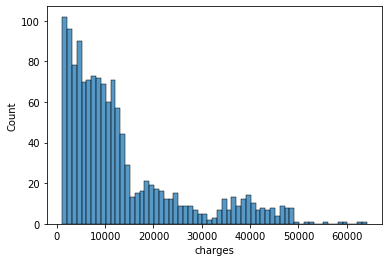

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.histplot(df['charges'], binwidth=1000);

The distribution of the dependent variable appears to be **log-normal**, as expected: this phenomenon is very common for strictly positive variables, especially amounts of money.

In [83]:
df.isna().sum().sum()

0

The whole dataset does not contain any **missing value**.

Let us give a quick look at the relationships between the independent variables, namely **correlation** and **multicollinearity**. This question is important for the computation of exact Shapley values because it is a permutation-based interpretation method: since it relies on random sampling, it will include unrealistic data instances if some features are correlated. For example, in order to estimate the importance of the feature *is a smoker*, it might randomly generate an observation that is 8 years old. Obviously/hopefully, this observation is very unrealistic. As a consequence of correlation/multicollinearity, the obtained Shapley values will be unreliable.

As a matter of fact, the Tree SHAP algorithm can solve this problem by modeling conditional expected predictions. But this comes at the cost of breaking [[1]](https://arxiv.org/abs/1908.08474) the symmetry property of the exact Shapley values: "The contributions of two feature values should be the same if they contribute equally to all possible coalitions" [[2]](https://christophm.github.io/interpretable-ml-book/shapley.html). So, the sum of Shapley values associated to correlated features will be consistent, but not their distribution. In other words, if features A and B are highly correlated, Tree SHAP may give different importances to A or B depending on the random seed of at the time the underlying model was built. And even if B does not have any influence on the dependent variable, it could be attributed a non-zero Shapley value.

The other reason why we are studying relationships between input variables is the absence of multicollinearity assumed by linear regression, which we will perform later on. Other assumptions, namely homoscedasticity and normality, are adressed once the model is built. Anyway, the residuals are very likely to be heteroscedastic: risky profiles (old, smoker, high BMI, etc...) are probably subject to a high variance of charges, while "safe" profiles might stay in the low-charges zone.

#### **Continuous variables**

Below is the **correlation** matrix of the continous columns, including the target:

In [84]:
df[['age', 'bmi', 'children', 'charges']].corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The Pearson's correlation coefficients between the input variables are very low. With that said, it is worth noting that the correlation between *age* and *bmi* is 10 times higher than the *age*/*children* and *bmi*/*children* correlations. The older the fatter, apparently...

In order to assess **multicollinearity**, the **Variance Inflator Factor** if often used. The relevance of this metric is debated for categorical variables. Let us compute VIFs for independent continuous variables only:

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols=['age', 'bmi', 'children']
iter_index=range(len(cols))
vifs=list(map(lambda x: round(variance_inflation_factor(df[cols].to_numpy(), x),2), iter_index ))

for i in iter_index:
    print(f'Feature \'{cols[i]}\': VIF = {vifs[i]}.')

Feature 'age': VIF = 7.54.
Feature 'bmi': VIF = 7.85.
Feature 'children': VIF = 1.8.


The VIFs of features *age* and *BMI* are moderately high, since common rules of thumb are to judge the amount of multicollinearity problematic if a VIF value is greater than 5 or 10 (see *An Introduction to Statistical Learning* for example). As a consequence, we shall fit a linear model with the two features together / only *age* / only *BMI*. Then, computing the RMSE on the test sample for each model and performing an analysis of variance will allow us to better grasp the multicollinearity problem.

As for the Random Forest model, multicollinearity is not a problem regarding performance. This is one of the reason this algorithm is so popular and efficient. However, it has **consequences on the interpretation part**. Due to the random feature selection that occurs while building a RF, the model may rely more on a correlated variable rather than an other for no other reason than chance. In the case of insurance costs, one RF may attribute more importance to *age* than to *BMI*, and the other way around for another RF. As SHAP explains the model and not the data, this phenomenon has a substantial impact on the SHAP values attributed to the said features.

This is something to keep in mind for the interpretation process when retaining potentially correlated features in the model.

#### **Continuous/categorical pairs of variables**

We are going to visually inspect the dependence between continuous and categorical variables using boxplots, even though metrics such as the [point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) exist (this one only works with binary variables though).

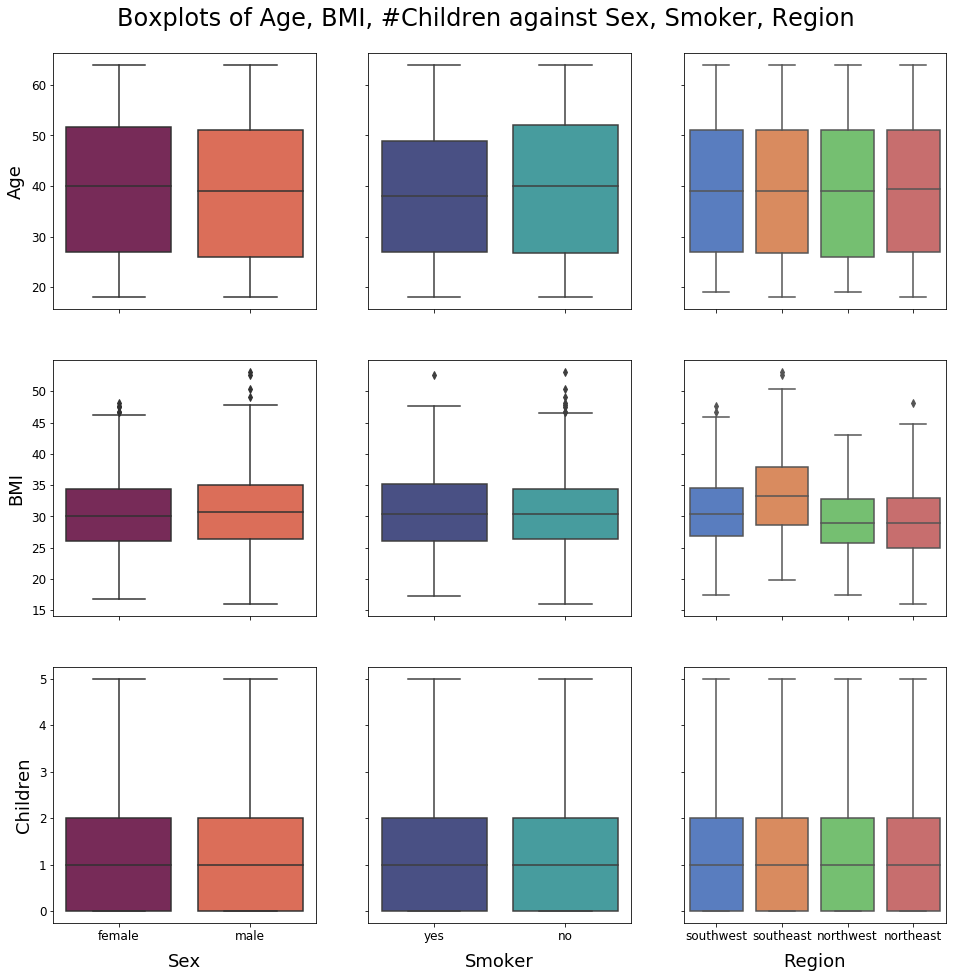

In [49]:
cate_vars = ['Sex', 'Smoker', 'Region']
cont_vars = ['Age', 'BMI', 'Children']
palettes = ['rocket', 'mako', 'muted']

nrows = len(cate_vars)
ncols = len(cont_vars)

fig, axes = plt.subplots(nrows, ncols, sharex = 'col', sharey = 'row', figsize=(16, 16))

for i in range(nrows):
    for j in range(ncols):
        axx = axes[j][i]
        sns.boxplot(
            x=cate_vars[i].lower(),
            y=cont_vars[j].lower(),
            data=df,
            orient='v',
            palette = palettes[i],
            ax=axx
        )
        axx.tick_params(axis='both', which='major', labelsize=12)
        if j==nrows-1:
            axx.set_xlabel(cate_vars[i], fontsize = 18, labelpad = 10)
        else:
            axx.set_xlabel('', fontsize = 18, labelpad = 10)
        if i==0:
            axx.set_ylabel(cont_vars[j], fontsize = 18, labelpad = 6)
        else:
            axx.set_ylabel('', fontsize = 18, labelpad = 6)
        
fig.suptitle(
    'Boxplots of Age, BMI, #Children against Sex, Smoker, Region',
    y=0.92,
    fontsize=24,
    fontfamily = 'sans-serif'
);

No clear relationships emerge from these plots. It is notable that nonsmokers are generally older than smokers. Also, people from the American Southeast tend to have a higher BMI than people from the other parts of the country: what is happening in Florida ?! The boxplots for the ordinal feature *# children* are moderately informative, but we are not going to push the analysis further as the main topic of this notebook is interpretability/SHAP.

#### **Categorical variables**

In [86]:
df_cat = df[['sex', 'smoker', 'region']]

Let us compute a R-style summary to count the values:

In [87]:
category_counts=list(map(lambda col: df[col].value_counts(), df_cat.columns))
for category in category_counts:
    print(category, "\n")

male      676
female    662
Name: sex, dtype: int64 

no     1064
yes     274
Name: smoker, dtype: int64 

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



The dataset is very well balanced regarding *sex* and *region*. This is less true regarding the *smoker* feature with around one smoker in four individuals, but the situation is far from being critical and does not require specific data processing in my experience.  
  
Now let us compute Cramér's V for each pair of distinct categorical variables. Since this metric is based on the $\chi²$ test of independence, each cell of the contingency tables should have a frequency greater than 5, otherwise the computed values will not be reliable.

In [88]:
cols=df_cat.columns.to_list()
for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        print(pd.crosstab(df[cols[i]], df[cols[j]]), "\n")

smoker   no  yes
sex             
female  547  115
male    517  159 

region  northeast  northwest  southeast  southwest
sex                                               
female        161        164        175        162
male          163        161        189        163 

region  northeast  northwest  southeast  southwest
smoker                                            
no            257        267        273        267
yes            67         58         91         58 



All combinations of levels have frequencies well above 5 so the Cramér's Vs below are highly reliable.

In [89]:
# Definition of Cramer's V
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [90]:
# Matrix of Cramer's Vs
import numpy as np

rows = []

for var1 in df_cat.columns:
    col = []
    for var2 in df_cat.columns :
        col.append(round(cramers_v(df_cat[var1], df_cat[var2]),2))
    rows.append(col)

cramer_matrix = pd.DataFrame(np.array(rows), columns = df_cat.columns, index = df_cat.columns)

In [91]:
cramer_matrix

,sex,smoker,region
sex,1.00,0.07,0.00
smoker,0.07,1.00,0.06
region,0.00,0.06,1.00


To each pair of distinct categorical features corresponds a very low Cramér's V. The categorical variables appear to be independent.

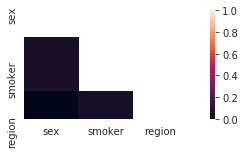

In [92]:
# For the record, let us plot a heatmap even if the number of features if very small
mask = np.zeros_like(cramer_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 2))
    ax = sns.heatmap(cramer_matrix, mask=mask, vmin=0., vmax=1, square=True)

#### **Conclusion**

On the whole, the features give every appearance of being uncorrelated, with reservations for the couple (*age*, *BMI*). The Variance Inflation Factors of these two variables are indeed a bit high. This fact encourages us to push further investigations with linear regression, and to be more careful when evaluating the Shapley values of these features if we were to retain them in the final model.

### 3) One-hot encoding

In [93]:
from sklearn.preprocessing import OneHotEncoder
# Drop one level for each categorical variable to avoid multicollinearity
enc = OneHotEncoder(drop=['female', 'no', 'northeast'], sparse=False).fit(df_cat)
col_names = enc.get_feature_names(df_cat.columns)
df_cat_ohe = pd.DataFrame(enc.transform(df_cat), columns=col_names)
df_ohe=pd.concat([df_cat_ohe, df[['age', 'bmi', 'children', 'charges']]], axis = 1)

In [94]:
df_ohe

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
0,0.0,1.0,0.0,0.0,1.0,19,27.900,0,16884.92400
1,1.0,0.0,0.0,1.0,0.0,18,33.770,1,1725.55230
2,1.0,0.0,0.0,1.0,0.0,28,33.000,3,4449.46200
3,1.0,0.0,1.0,0.0,0.0,33,22.705,0,21984.47061
4,1.0,0.0,1.0,0.0,0.0,32,28.880,0,3866.85520
...,...,...,...,...,...,...,...,...,...
1333,1.0,0.0,1.0,0.0,0.0,50,30.970,3,10600.54830
1334,0.0,0.0,0.0,0.0,0.0,18,31.920,0,2205.98080
1335,0.0,0.0,0.0,1.0,0.0,18,36.850,0,1629.83350
1336,0.0,0.0,0.0,0.0,1.0,21,25.800,0,2007.94500


### 4) Train/Test samples

In [95]:
# Train-test splitting
from sklearn.model_selection import train_test_split

x, y = df_ohe.drop(columns='charges'), df_ohe['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 5) Linear regression / Multicollinearity

We are going to train 6 models and we will keep the one that minimizes the test sample's RMSE:
* Since the target is an amount of money that seems to be log-normal, log-transforming the charges could help increase accuracy (2 models)
* Based on the feature analysis, we doubt wether we should include *age*, *BMI* or both variables in the model (3 models)

That makes $3 \times 2 = 6$ possibilities.

#### **Linear models**

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from copy import deepcopy

# Dictionaries for the 6 linear models and associated RMSEs on the test samples
lm={'No transformation': {'Age only': None, 'BMI only': None, 'Both age and BMI': None}, 'Log-transformation': {'Age only': None, 'BMI only': None, 'Both age and BMI': None}}
rmse=deepcopy(lm)

# Adapt the input and output for each model
y_trains={'No transformation': y_train, 'Log-transformation': np.log(y_train)}
x_trains={'Age only': x_train.drop(columns='bmi'), 'BMI only': x_train.drop(columns='age'), 'Both age and BMI': x_train}
x_tests={'Age only': x_test.drop(columns='bmi'), 'BMI only': x_test.drop(columns='age'), 'Both age and BMI': x_test}

# Build the 6 linear models
for transformation in rmse.keys():
    for fset in x_trains.keys():
        lm[transformation][fset]=LinearRegression().fit(x_trains[fset], y_trains[transformation])
        predictions=lm[transformation][fset].predict(x_tests[fset]) if transformation=='No transformation' else np.exp(lm[transformation][fset].predict(x_tests[fset]))
        rmse[transformation][fset]= round((mean_squared_error(y_test, predictions))**(1/2))

In [98]:
import pprint
pprint.pprint(rmse)

{'Log-transformation': {'Age only': 8479.0,
                        'BMI only': 6669.0,
                        'Both age and BMI': 7815.0},
 'No transformation': {'Age only': 6142.0,
                       'BMI only': 6836.0,
                       'Both age and BMI': 5796.0}}


The models built with the log-transformed target perform worse than the others on the test sample. The lowest RSME obtained by log-transforming the charges—*BMI only*—is almost \\$1 000 higher than the lowest RMSE with no transformation (*Both age and BMI*). This represents a significant amount given the range of the charges, and the range of the different RMSEs computed here. Therefore, it is clear that log-transforming the target variable did not improve the results even if the charges seem to be log-normally distributed. We will not perform a Kolmogorov-Smirnov test to verify this assertion here.
  
#### **Multicollinearity**

We have seen that the features *age* and *BMI* both have moderately high variance inflation factors, which suggests that maybe one of them could be excluded to improve the model and make interpretations more reliable. However, including both variables has yielded the lowest out-of-sample RMSE, while excluding the *BMI* increases it by approximately \\$350. Is this significant ?

Let us switch to R to perform an analysis of variance of the nested models with/without the *BMI* variable. The F-statistic will help us to determine if the full model yields a significant drop in sum of square errors or not. In this case, we are testing the nullity of only one feature so the F-statistic is equivalent to the t-statistic of *BMI* in the full model ($F = t²$). The associated p-values are equal.

We will also evaluate the homoscedasticity and normality of the residuals that are assumed by analysis of variance.

In [99]:
pd.concat([x_train, y_train], axis=1).to_csv('data_r/df_train.csv', index=False)

```r
# Packages
library(here)
library(readr)
library(tibble)
library(dplyr)
library(ggplot2)

# Import the training set
df <- read_csv(here('data_r/df_train.csv'))

# Compute the t-statistic of BMI in the full model
lm_full <- lm(charges~., data=df)
summary(lm_full)
```

![BMI t-statistic](plots_r/bmi_t-statistic.png)

```r
# Or compute the F-statistic of the nested models (equivalent to the t-statistic because we add only one feature)
lm_no_bmi <- lm(charges~.-bmi, data=df)
anova(lm_no_bmi, lm_full)
```

![BMI F-statistic](plots_r/bmi_F-statistic.png)

The t-statistic of the BMI is very high, so much that the associated p-value is negligible. But what about the assumptions made by this test of nullity ?

##### **Homoscedasticity**

<img src="plots_r/studentized_residuals.png" alt="Homoscedasticity" style="width: 400px; height: 592px"/>

The residuals show heteroscedasticity. Nonetheless, the situation is *not* disastrous. The red lines represent the 95% centered confidence interval of the Student distribution and it turns ou that 5.14 % of the observations are outside these bounds (see R script). However, all these observations have a studentized residual greater than 2 and not one is less than -2, i.e there is no symmetry.  
  
The residuals are homoscedastic until charges approximately equal to \\$15 000. After that, clearly the heteroscedasticity "begins". It is notable that between \\$15 000 and \\$30 000, the model either underestimates or overestimates the charges. Above \\$35 000, the model underestimate the charges. **High charges are underestimated by the linear model.**

On the whole, the residuals of this linear regression are faintly heteroscedastic. Given the size of the sample (around 800 observations), this phenomenon should not have major consequences on inference. Indeed, an important sample size stabilizes the standard errors estimates used to compute the statistics for significance testing and confidence intervals/p-value.

##### **Normality**

<img src="plots_r/qq_plot.png" alt="Normality" style="width: 400px; height: 592px"/>

The Q-Q plot shows that the assumption of normality for the residuals does not hold well. A high proportion of observations shows low residuals. Then, after fitting the normal quantiles for a significant part of the observations, the residuals show extreme values, greater than if they were normally distributed.  
  
Once again, we cannot conclude the the assumption of normality holds, but the situation is not catastrophic either. Besides, significance testing in linear models is robust to non-normality, see [[3]](https://www.biorxiv.org/content/10.1101/498931v2.full) for example.

##### **Conclusion**

Considering the moderately high variance inflation factors for the features *age* and *BMI*, we suspected **multicollinearity** in the input features. Performing linear regression with different subsets of features suggested that the *BMI* might not bring substantial information to model *insurance charges*. Then, an analysis of variance of the linear model with and without the BMI feature assessed a very high significance for the *BMI* variable. This conclusion could be challenged by the moderate heteroscedasticity and non-normality of the residuals. However, the size sample mitigates the impact of heteroscedasticity and ANOVA is robust to non-normality. Besides, given the negligible p-value associated with the extremely high value for the t-statistic, we conclude that the ***BMI* should be included** in the feature set to model the insurance charges and we rule out the hypothetical problematic multicollinearity of the input variables.
  
Given this outcome, the estimated **Shapley values** of both *age* and *BMI* will be reliable.

### 6) Random Forest

We are going to perform a grid search using the 8 cores of the P4000 we are working on.

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_parameters = {
    'n_estimators': [100, 250, 500, 1000, 1500, 2000],
    'min_samples_split': [2, 10, 50, 100, 200, 500],
    'max_features': list(range(1,len(x_train.columns)+1))
}

rf_gridsearch = GridSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_grid=rf_parameters,
    cv=5,
    n_jobs=8, # Change this before reproducing on another machine
    scoring='neg_mean_squared_error',
    verbose=1
)

In [63]:
rf_gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   33.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 1440 out of 1440 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7

In [64]:
rf_gridsearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

The best estimator consists in 500 trees. They are quite deep since the minimum number of samples required to split an internal node (*min_samples_split*) is only 10. The best number of features picked to look for the best split (max_features) is 4. This is close to the common value *sqrt(num_features)*.

In [100]:
from joblib import dump, load
#dump(rf_gridsearch, 'rf_gridsearch_charges.joblib')
rf_gridsearch = load("rf_gridsearch_charges.joblib")

In [101]:
rmse_rf=round((-rf_gridsearch.score(x_test, y_test))**(1/2),2)
rmse_lm=rmse["No transformation"]["Both age and BMI"]

In [102]:
f'Test RMSE obtained with the best Random Forest estimator: ${rmse_rf}.'

'Test RMSE obtained with the best Random Forest estimator: $4365.38.'

In [103]:
f'Test RMSE obtained with the best linear model: ${rmse_lm}.'

'Test RMSE obtained with the best linear model: $5796.0.'

In [104]:
f'Drop of RMSE: {round(100*(rmse_lm-rmse_rf)/rmse_lm,2)}%.'

'Drop of RMSE: 24.68%.'

A straightforward hyperparameter tuning of the Random Forest algorithm with grid search improved the RMSE by 25%. Similar results could possibly be achieved by regularizing the linear model, engineering the features (other transformations of the target variable for example), identifying non-linear relationships with predictors, etc... But this is highly time-consuming in comparison with a mere grid search for the parameters of a tree ensemble.

Despite their efficiency and accuracy, algorithms like Random Forest are often dismissed because they are black box models. This is especially the case in regulated fields such as finance or healthcare. The Shapley values and their estimation with Tree SHAP is a major breakthrough in the quest for getting the best of both worlds.

### 7) Interpretation with SHAP

Now, we compute the estimated Shapley values for the test sample. We build our regressor's `shap.TreeExplainer` with the `feature_perturbation` parameter set to the default value, 'interventional'. This means that it relies on marginal distributions of the input features, not conditional distributions: see https://github.com/slundberg/shap/issues/1098 and [[4]](https://arxiv.org/abs/1905.04610) for more in-depth explanations. Since we have achieved substantial work to rule out multicollinearity, the estimation of the Shapley values is dependable. One would describe this explainer as being "true to the model" while it would be "true to the data" when `feature_perturbation='tree_path_dependent'`.

In [106]:
import shap
shap.initjs() # JavaScript plots

# Generate the Tree SHAP estimator of Shapley values that corresponds to the Random Forest we built
explainer = shap.TreeExplainer(rf_gridsearch.best_estimator_, feature_perturbation='interventional')
# Compute the estimated Shapley values for the test sample's observations
shap_values = explainer.shap_values(x_test)

In [107]:
# Visualize a few observations: input features, real amount of billed charges and predictions
df_test=pd.concat([x_test, y_test], axis=1).reset_index().drop(columns='index')
df_test['charges_pred']=list(map(lambda x: round(x,2), rf_gridsearch.best_estimator_.predict(x_test)))
df_test['charges']=list(map(lambda x: round(x,2), df_test['charges']))
df_test[:10]

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children,charges,charges_pred
0,0.0,0.0,0.0,0.0,0.0,45,25.175,2,9095.07,10940.59
1,0.0,0.0,1.0,0.0,0.0,36,30.020,0,5272.18,5871.81
2,0.0,1.0,1.0,0.0,0.0,64,26.885,0,29330.98,28045.68
3,1.0,0.0,1.0,0.0,0.0,46,25.745,3,9301.89,11046.10
4,1.0,1.0,1.0,0.0,0.0,19,31.920,0,33750.29,34405.08
5,1.0,0.0,0.0,0.0,1.0,34,42.900,1,4536.26,7325.33
6,0.0,0.0,1.0,0.0,0.0,19,22.515,0,2117.34,2802.88
7,1.0,0.0,1.0,0.0,0.0,64,37.905,0,14210.54,15479.72
8,0.0,0.0,0.0,0.0,0.0,28,17.290,0,3732.63,5827.42
9,1.0,0.0,1.0,0.0,0.0,49,28.690,3,10264.44,11542.12


##### **Explaining predictions for individual observations**

Let's visualize the explainer's estimation of Shapley values for given observations. The baseline for Shapley values is the average of all predictions from the training set.

In [108]:
f'Baseline of the Shapley values: ${round(np.mean(rf_gridsearch.best_estimator_.predict(x_train)))}'

'Baseline of the Shapley values: $13396.0'

Then, each feature's Shapley value is added or substracted from this baseline to explain a given prediction. For example, billed charges were important for individual \#2. These charges were very well anticipated by the model. Let us compute the Shapley values for this observation.

In [109]:
observation=2
shap.force_plot(explainer.expected_value, shap_values[observation,:], x_test.iloc[observation,:])

This plot shows how each feature moves the prediction away from the baseline. The smoking habit of this individual is what drives the prediction above the baseline the most, closely followed by age. This person is in fact the eldest in the dataset. Its reasonable BMI (generally considered to be balanced for values between 18 and 25) "pulls" the prediction towards the left, that is decreases the prediction for billed health charges.

In [110]:
observation=6
shap.force_plot(explainer.expected_value, shap_values[observation,:], x_test.iloc[observation,:])

Observation \#6 has very low predicted (and observed) charges. His young age and the fact that he does not smoke explain the most part of this prediction. The influence of the *BMI* is less significant here.  
  
Of course, the model failed to predict the billed charges in a number of cases:

In [114]:
df_test['residual']=df_test['charges']-df_test['charges_pred']
df_test.sort_values(by='residual').tail()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children,charges,charges_pred,residual
116,1.0,0.0,0.0,0.0,0.0,60,28.595,0,30260.00,12917.64,17342.36
143,0.0,0.0,1.0,0.0,0.0,52,37.525,2,33471.97,14620.86,18851.11
266,0.0,1.0,0.0,1.0,0.0,54,47.410,0,63770.43,44911.14,18859.29
52,0.0,0.0,1.0,0.0,0.0,40,41.420,1,28476.73,7687.89,20788.84
110,1.0,0.0,0.0,0.0,1.0,19,33.100,0,23082.96,1936.66,21146.30


Let us see what happened with the highest residual. The model predicted less than \\$2 000, but the individual was charged more than \\$20 000:

In [115]:
observation=110
shap.force_plot(explainer.expected_value, shap_values[observation,:], x_test.iloc[observation,:])

We can see why the model predicted low charges for individual \#110. Basing our judgment on the population's characteristics (not WHO's standards...), he has a moderately high BMI: the mean of the whole population is at 30, and the third quartile at 34). Apart from that, the estimator had every reason to output a low prediction.

##### **Explaining the whole model**

I find SHAP to be the most impressive with individual explanations because this is something we had never seen before—as far as I know—with black box models. A summary plot of all computed Shapley values gives a sense of the global behavior of the model.

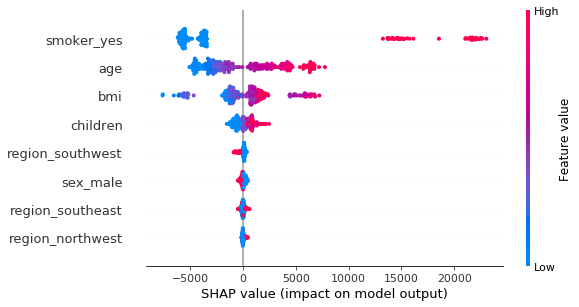

In [116]:
shap.summary_plot(shap_values, x_test)

On the y-axis, the features are sorted by decreasing order of importance. The importance of a feature is defined as the mean of the absolute value of all the computed SHAP values. This plot is much more informative than the usual out-of-bag feature importance plot for tree ensembles, because we can see *how* the variables affect the prediction. The color represents the feature value. For categorical variables, red means "yes" and blue means "no" according to the way they were one-hot encoded.  All the points are the studied individuals, vertically jittered when to close to each other.
  
For example, we can see that if not smoking significantly reduces the predicted charges, smoking *dramatically* increases the prediction: the rise is actually greater than the drop. This information is much harder, if not impossible, to grasp with the usual aggregated feature importance metric. 

Let us compare the importance of the variables computed with SHAP values *versus* Random Forest.

##### SHAP

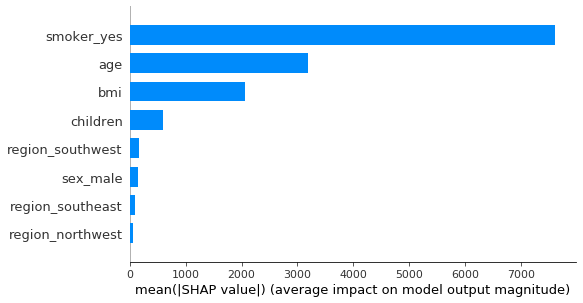

In [117]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

##### Random Forest

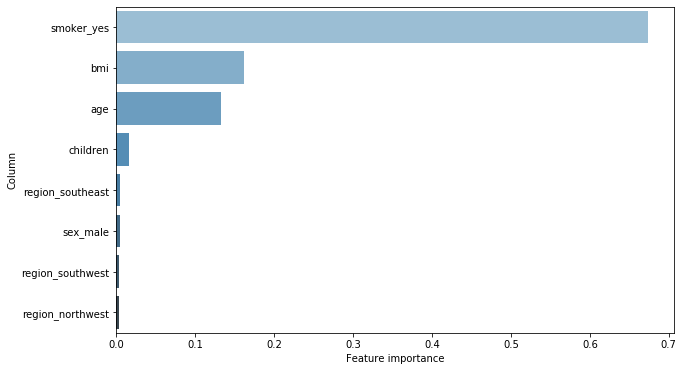

In [118]:
features_importance=pd.DataFrame(
    {
        'Column': x_train.columns,
        'Feature importance': rf_gridsearch.best_estimator_.feature_importances_
    }
).sort_values('Feature importance', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
ax=sns.barplot(x="Feature importance", y="Column", data=features_importance, palette="Blues_d", orient='h');

In [119]:
rf_gridsearch.best_estimator_.feature_importances_

array([0.00440498, 0.67336895, 0.00333147, 0.00486296, 0.00333244,
       0.13316856, 0.16192976, 0.01560087])

Since the SHAP feature importance is the mean of the Shapley values (in absolute value), it is expressed in terms of dollars. The average effect of smoking is plus or minus \\$7 000, starting from the baseline prediction (\\$13 400). Whereas with Random Forest, we only know it is around 67%. We can just compare this value with the other features' importance.  

Besides, the feature importance given by the two methods are similar but not identical. The *BMI* comes before *age* according to Random Forest, while SHAP tells the contrary. In addition, the values are closer with Random Forest. It could be that the small correlation (0.11) between these two features makes it hard to evaluate their real importance. However, telling who is right between SHAP or RF is beyond my knowledge.

##### **Feature interaction**

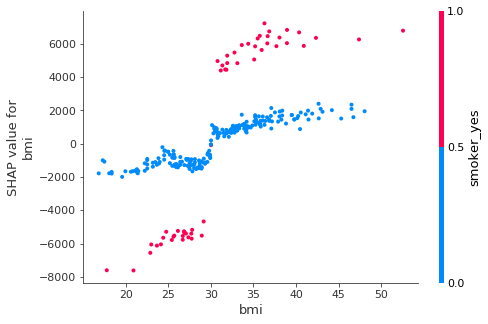

In [157]:
shap.dependence_plot('bmi', shap_values, x_test)

In [154]:
shap.force_plot(explainer.expected_value, shap_values, x_test)

### References

[[1]](https://arxiv.org/abs/1908.08474) Sundararajan, Mukund, and Amir Najmi. *The many Shapley values for model explanation.* arXiv preprint arXiv:1908.08474 (2019).

[[2]](https://christophm.github.io/interpretable-ml-book/shapley.html) Molnar, Christoph. *Interpretable machine learning. A Guide for Making Black Box Models Explainable*, 2019. [https://christophm.github.io/interpretable-ml-book/](https://christophm.github.io/interpretable-ml-book/).

[[3]](https://www.biorxiv.org/content/10.1101/498931v2.full) Ulrich Knief, Wolfgang Forstmeier. *Violating the normality assumption may be the lesser of two evils* (2020)  

[[4]](https://arxiv.org/abs/1905.04610) Lundberg et al, *Explainable AI for Trees: From Local Explanations to Global Understanding* (2019)
